In [1]:
import pandas as pd
import numpy as np
import GPy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
dataset = pd.read_csv('./Datasets/merged.csv')

In [3]:
dataset.head(2)

,date,hour,obs_count,n_month,n_week_in_month,day_of_week,day_of_week_name,is_weekend_day,day_of_week_name_short,ts,...,cur__windGust,cur__windBearing,cur__cloudCover,cur__uvIndex,cur__visibility,daily__summary,daily__sunriseTime,daily__sunsetTime,daily__temperatureHigh,daily__temperatureLow
0,2019-09-09 00:00:00,7,2,9,2,0,Monday,0,WeekDay,1568010600,...,43.38,311,0.26,0,16.093,Possible drizzle in the morning.,1568008740,1568055900,16.6,7.01
1,2019-09-09 00:00:00,8,3,9,2,0,Monday,0,WeekDay,1568014200,...,44.96,316,0.26,0,16.093,Possible drizzle in the morning.,1568008740,1568055900,16.6,7.01


In [4]:
num_features = ['hour', 'n_month', 'day_of_week', 'is_weekend_day', 'cur__precipIntensity', 'cur__precipProbability',
     'cur__temperature', 'cur__apparentTemperature', 'cur__humidity', 'cur__windSpeed', 'cur__windGust',
     'cur__cloudCover', 'cur__uvIndex', 'cur__visibility', 'daily__temperatureHigh']
X = dataset[num_features]
y = dataset['obs_count']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# choose subset of features to improve speed and accuracy
use_feats = 'hour,cur__precipIntensity,cur__apparentTemperature,cur__uvIndex,is_weekend_day'.split(',')

# scale data using standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[use_feats])
y_train_reshaped = np.expand_dims(y_train, axis=1)

# create kernel (tried adding periodic kernel Matern52 and it did not improve the performance)
kernel_radial = GPy.kern.RBF(X_train_scaled.shape[1], ARD=True)

# create likelihood for the model and inference method
poisson_likelihood = GPy.likelihoods.Poisson()
laplace_inf = GPy.inference.latent_function_inference.Laplace()

# run Gaussian process and optimize parameters
m = GPy.core.GP(X=X_train_scaled, Y=y_train_reshaped, likelihood=poisson_likelihood,
                inference_method=laplace_inf, kernel=kernel_radial)
m.optimize()  # more th

now optimizing with all data


In [10]:
#check the estimated parameters
m.kern

rbf.,value,constraints,priors
variance,2.946813195311062,+ve,
lengthscale,"(5,)",+ve,


In [11]:
# generate predictions from the scaled test data,
# GPy returns a tuple of 2 lists (means and variances)
X_test_scaled = scaler.transform(X_test[use_feats])
preds1 = m.predict(Xnew=X_test_scaled, include_likelihood=True)

In [15]:
preds1[1].shape

(828, 1)

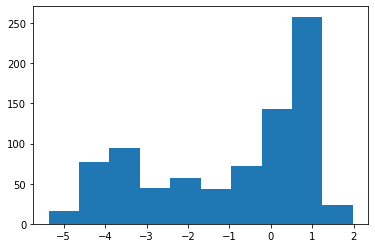

In [17]:
#I now predict directly the mean function (just for your understanding)
preds = m.predict_noiseless(Xnew=X_test_scaled, full_cov=True)
plt.hist(preds[0]); #this is the mean function of the GP
sampled_functions = np.random.multivariate_normal(preds[0][:,0], preds[1], 500)#sampling from the posterior

In [22]:
preds[0][:,0].shape

(828,)

In [24]:
preds[1][0].shape

(828,)

In [18]:
sampled_functions.shape

(500, 828)

In [26]:
preds1[0][:10]

array([[2.2890736 ],
       [0.01191219],
       [0.26697525],
       [3.58635602],
       [3.62768336],
       [0.02371747],
       [1.80726426],
       [0.45637528],
       [0.18264659],
       [0.73816629]])

In [25]:
# the Poisson intensity is defined as exp(f), so
exp_sampled_functions=np.exp(sampled_functions)
mean_intensity=np.mean(exp_sampled_functions,axis=0).reshape(-1,1) # approximatively this is what is in preds1[0]
mean_intensity[:10] #this is the mean intensity function estimated by the GP

array([[2.27390536],
       [0.01179618],
       [0.27024181],
       [3.62701047],
       [3.59648424],
       [0.02309901],
       [1.81352887],
       [0.45178288],
       [0.18246848],
       [0.77925775]])

In [27]:
mean_intensity[4]

array([3.59648424])

In [32]:
y_test.values[4]

6

In [30]:
import scipy as sp
sp.stats.poisson(mean_intensity[4]).pmf([0,1,2,3,4,5,6])

array([0.02741996, 0.09861544, 0.17733443, 0.2125935 , 0.19114729,
       0.13749164, 0.08241442])

the mean intensity gives you the mean rate of the posson distribution, as higher as larger is the number of events for that relative row (X_test)

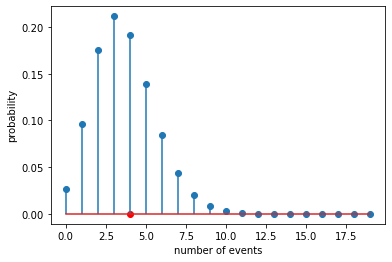

In [35]:
import scipy as sp
xx= np.arange(0,20)
i=3#let's fix one test point
plt.stem(xx, sp.stats.poisson(mean_intensity[i]).pmf(xx), use_line_collection=True)
plt.ylabel('probability')
plt.xlabel('number of events')
plt.scatter(y_test.values[i], 0, color='r')#true event

In [46]:
#your point estimator of the counts should be mean intensity 
estimator = mean_intensity[i][0] #this the average of the above distribution
print(np.sum(xx*sp.stats.poisson(mean_intensity[i]).pmf(xx)), estimator) # note that they are equal

3.6270104264822027 3.6270104678460924


In [41]:
sp.stats.poisson(mean_intensity[i]).pmf(xx)

array([2.65955740e-02, 9.64624253e-02, 1.74935113e-01, 2.11497162e-01,
       1.91775605e-01, 1.39114426e-01, 8.40949130e-02, 4.35733042e-02,
       1.97551038e-02, 7.96132982e-03, 2.88758266e-03, 9.52117503e-04,
       2.87778346e-04, 8.02903902e-05, 2.08010061e-05, 5.02969780e-06,
       1.14017291e-06, 2.43259946e-07, 4.90170206e-08, 9.35711824e-09])

In [47]:
#you can then compute the MSE as
np.mean((mean_intensity[:,0] - y_test.values)**2)

2.3496432687649373

In [58]:
np.std(exp_sampled_functions, axis=0)[2]

0.06353774673455517

In [68]:
X_test.iloc[418]

hour                        16.0000
n_month                      9.0000
day_of_week                  5.0000
is_weekend_day               1.0000
cur__precipIntensity         2.7909
cur__precipProbability       0.8400
cur__temperature            13.2400
cur__apparentTemperature    13.2400
cur__humidity                0.9600
cur__windSpeed              20.3200
cur__windGust               26.0600
cur__cloudCover              0.9900
cur__uvIndex                 1.0000
cur__visibility             11.7840
daily__temperatureHigh      15.3500
Name: 465, dtype: float64

In [67]:
ind=np.argsort(np.std(exp_sampled_functions, axis=0))#sort instances with higher variance

ind[-1]

# #this is an instance with low uncertainty, can you explain it from the values of Xtest?
# i=ind[0]#is it night?
# plt.stem(xx,sp.stats.poisson(mean_intensity[i]).pmf(xx))
# plt.ylabel('probability')
# plt.xlabel('number of events')
# plt.scatter(y_test.values[i],0,color='r')#true event

# plt.figure()
# #this is an instance with high uncertainty, can you explain it from the values of Xtest?
# i=ind[-2]
# plt.stem(xx,sp.stats.poisson(mean_intensity[i]).pmf(xx))
# plt.ylabel('probability')
# plt.xlabel('number of events')
# plt.scatter(y_test.values[i],0,color='r')#true event

418

In [112]:
kernel1 = GPy.kern.RBF(X_train_scaled.shape[1], ARD=True) + GPy.kern.StdPeriodic(
    X_train_scaled.shape[1], ARD1=True, ARD2=True)

# create likelihood for the model and inference method
poisson_likelihood = GPy.likelihoods.Poisson()
laplace_inf = GPy.inference.latent_function_inference.Laplace()

# run Gaussian process and optimize parameters
m = GPy.core.GP(X=X_train_scaled, Y=y_train_reshaped, likelihood=poisson_likelihood,
                inference_method=laplace_inf, kernel=kernel1)
m.optimize(max_iters=100, messages=True)

predict noiseless

In [113]:
# I now predict directly the mean function (just for your understanding)
preds = m.predict_noiseless(Xnew=X_test_scaled, full_cov=True)
sampled_functions = np.random.multivariate_normal(preds[0][:,0], preds[1], 500)#sampling from the posterior

# the Poisson intensity is defined as exp(f), so
exp_sampled_functions=np.exp(sampled_functions)
mean_intensity=np.mean(exp_sampled_functions,axis=0).reshape(-1,1) # approximatively this is what is in preds1[0]

In [114]:
np.mean((mean_intensity[:,0]-y_test.values)**2)

2.515243110931229

In [89]:
uncertainties = np.std(exp_sampled_functions, axis=0)

In [93]:
np.min(uncertainties), np.max(uncertainties)

(0.004565093601253444, 8.238560414382555)

In [103]:
uncertainties[uncertainties > 0.8].shape

(22,)

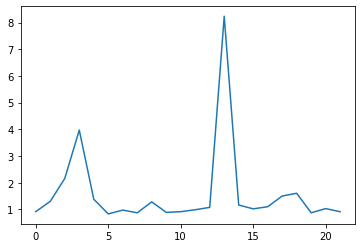

In [102]:
plt.plot(uncertainties[uncertainties > 0.8]);